## MVP Engenharia de Dados

**Nome:** Marcolino Matheus de Souza Nascimento

**Matrícula:** 4052025001107

### Conjunto de dados

[Brazil Weather Information by INMET](https://www.kaggle.com/datasets/gregoryoliveira/brazil-weather-information-by-inmet)

O dataset escolhido para este projeto foi o histórico de dados observados do INMET. Cada linha desse dataset descreve o registro de sensores meteorológicos como temperatura, precipitação e vento, em um determinado momento (data e hora) e em um determinado local (estação meteorológica, latitude, longitude, etc).

As informações sobre a localização, são constantes (fixas) e referentes ao inventário da estação. Aplicando boas práticas de armazenamento de dados, o dataset foi dividido em um arquivo único para o inventário das estações (evitando repetição) e em 26 arquivos anuais para histórico das leituras. As colunas `ESTACAO` ou `id_station` estabelecem a relação entre a leitura e as informações da estação.

#### Análise por atributoPresença de valores nulos
A análise de qualidade dos dados foi realizada atributo a atributo, considerando tanto os dados meteorológicos quanto os dados cadastrais das estações. Foram avaliados principalmente os seguintes aspectos:
- **Consistência de tipos de dados:** Os dados meteorológicos apresentavam, inicialmente, inconsistências de tipo, pois eram carregados como texto. Esse problema foi resolvido por meio da conversão explícita para tipos numéricos (double).
- **Padronização de nomes e formatos:** Além disso, foi realizada a padronização dos nomes das colunas, removendo caracteres especiais e adotando nomenclatura em snake_case, o que facilita consultas SQL, integrações e manutenção do pipeline.
- **Coerência temporal dos registros:** Nos dados das estações, atributos como datas de início e fim de operação estavam armazenados como texto. Esses campos foram convertidos para o tipo timestamp, garantindo consistência temporal e possibilitando análises baseadas em períodos de funcionamento.
- **Integridade entre tabelas relacionadas:** Para garantir a qualidade das análises posteriores, foi aplicado um filtro que mantém apenas registros com valores não nulos nas variáveis meteorológicas. No caso específico da variável de radiação, valores ausentes foram preenchidos com zero, por se tratar de uma medida que pode ser legitimamente nula no período noturno.

#### Conclusão da qualidade dos dados

Após as transformações aplicadas, não foram identificados problemas críticos que comprometessem a análise. Os dados passaram a apresentar:
- Tipos adequados;
- Baixo nível de valores ausentes nas variáveis essenciais;
- Coerência temporal;
- Relacionamento consistente entre estações e medições meteorológicas.

Dessa forma, o conjunto de dados foi considerado adequado e confiável para a etapa de análise e solução do problema.


### Objetivo
- Analisar o histórico da rede de estações do INMET, identificar padrões temporais de instalação e desativação, além de categorizar as estações como novas ou antigas, ativas ou inativas, permitindo avaliar a estabilidade e expansão da rede ao longo do tempo.
- Analisar a climatologia das estações mais representativas de cada região do Brasil e a correlação entre as variáveis (exemplo: precipitação e vento).

### Perguntas

- A maior parte da rede do INMET é composta por estações antigas e ainda ativas.
- Qual a distribuição de estações por região?
- Qual estação pode ser considerada a mais representativa de cada região?
- Quais os 5 estados com maior número de estações meteorológicas?
- Quais são os 5 estados com menos estações meteorológicas no Brasil?
- Existe correlação entre precipitação e as demais variáveis?
- A amplitude térmica anual cresce progressivamente do Norte para o Sul do Brasil?


In [0]:
import calendar

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pyspark.sql import functions as F

In [0]:
spark.sql("USE CATALOG mvp")
spark.sql("USE SCHEMA gold")

DataFrame[]

In [0]:
df_gold_stations = spark.table("stations").toPandas()

### Agregação por status combinado das estações

Nesta célula, os dados da tabela Gold são agrupados pelo campo `combined_status` para gerar métricas resumidas. Para cada categoria de status, é calculado o número de estações (`count` de `code`, renomeado para `stations`) e a média do tamanho do período de registros (`mean` de `period_size`), permitindo uma análise comparativa do perfil operacional das estações.


In [0]:
df_gold_stations.groupby('combined_status').agg({'code': 'count', 'period_size': 'mean'}).rename(columns={'code': 'stations'})

,stations,period_size
combined_status,,
New & Active,79,2759.569620
New & Inactive,48,1242.687500
Old & Active,411,6507.211679
Old & Inactive,77,5590.116883


#### Análise
Nota-se que é uma rede formada em sua maioria por estações antigas e em funcionamento, demonstrando uma sólida base de dados históricos. Além disso, existem mais estações novas ativas do que antigas e inativas. A longo prazo e mantendo essa proporção, a tendência é de que a rede se renove cada vez mais, pois o número de estações inauguradas que ainda estão funcionando é superior ao número de estações antigas que não estão mais em operação.

### Visualização da distribuição espacial das estações

Nesta célula, é realizada uma análise exploratória da distribuição das estações por **região** e por **estado**. Inicialmente, são calculadas as contagens de estações agrupadas por região e por UF. Em seguida, essas informações são visualizadas em dois gráficos complementares:  
- um **gráfico de pizza**, que mostra a proporção relativa de estações por região;  
- um **gráfico de barras horizontal**, que apresenta o número absoluto de estações por estado, com rótulos de valores para facilitar a leitura.

Essa visualização permite compreender rapidamente a cobertura espacial das estações e identificar concentrações regionais e estaduais.

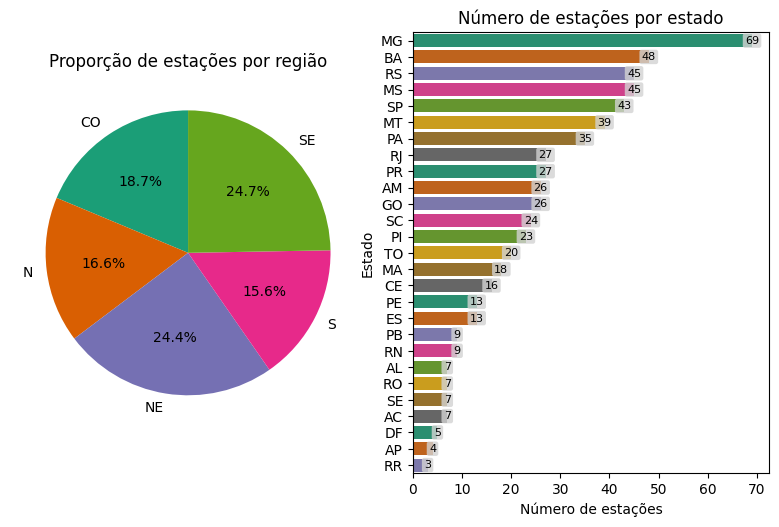

In [0]:
# Visualizando rapidamente a distribuição de estações.
region_counts = df_gold_stations.groupby('region').size()
state_counts = (
    df_gold_stations
    .groupby('uf')
    .size()
    .sort_values(ascending=False)
)
df_state_counts = state_counts.reset_index()
df_state_counts.columns = ['uf', 'count']

# Plots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(8,5))

# Gráfico de pizza
axes[0].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Dark2'))
axes[0].set_title('Proporção de estações por região')
plt.tight_layout()

# Gráfico de barras horizontal
sns.barplot(
    data=df_state_counts,
    x='count', y='uf',
    hue='uf',
    palette='Dark2',
    dodge=False,
    legend=False,
    ax=axes[1]
)

axes[1].set_title('Número de estações por estado')
axes[1].set_xlabel('Número de estações')
axes[1].set_ylabel('Estado')

# Adiciona labels nas barras
for i, v in enumerate(state_counts.values):
    axes[1].text(
    v, i, str(v),
    va='center', ha='center', fontsize=8,
    bbox=dict(facecolor='lightgray', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
    )

#### Análise

A rede do INMET é concentrada no Sudeste e Nordeste, que abrigam, respectivamente, 24,7% e 24,4% das estações nacionais. As regiões Centro-Oeste (18,7 %), Norte (16,6 %) e Sul (15,6 %) ficam atrás.

No detalhe por estado, **Minas Gerais** lidera isolado com 69 estações, seguido do par **Rio Grande do Sul** e **Mato Grosso do Sul** (45 cada) e da **Bahia** (48). Estados amazônicos e do Nordeste como  **Roraima** (3), **Amapá** (4) e **Alagoas** (7), possuem cobertura modesta, evidenciando lacunas regionais que podem afetar a representatividade de monitoramento climático e a qualidade de serviços meteorológicos locais.

### Identificação das estações com maior histórico por região

Nesta célula, é identificada, para cada região, a estação que possui o maior período de registros (`period_size`). Para isso, é obtido o índice do maior valor por região e, em seguida, são selecionadas e ordenadas as estações correspondentes, permitindo analisar quais estações têm a série histórica mais longa em cada região.


In [0]:
# índice da maior série em cada região
idx = df_gold_stations.groupby('region')['period_size'].idxmax()

# estações com o maior período por região
stations_longest = df_gold_stations.loc[idx].sort_values('region')

display(stations_longest)

region,uf,city,code,first_record,last_record,period_size,status,inactive,combined_status
CO,DF,BRASILIA,A001,2000-05-07T00:00:00.000Z,2025-05-31T00:00:00.000Z,9155,Old,false,Old & Active
N,AM,MANAUS,A101,2000-05-09T00:00:00.000Z,2025-05-31T00:00:00.000Z,9153,Old,false,Old & Active
NE,BA,SALVADOR,A401,2000-05-13T00:00:00.000Z,2025-05-31T00:00:00.000Z,9149,Old,false,Old & Active
S,RS,PORTO ALEGRE,A801,2000-09-22T00:00:00.000Z,2025-05-31T00:00:00.000Z,9017,Old,false,Old & Active
SE,RJ,ECOLOGIA AGRICOLA,A601,2000-05-07T00:00:00.000Z,2025-05-31T00:00:00.000Z,9155,Old,false,Old & Active


### Filtragem dos dados das estações com maior série histórica

Nesta célula, a tabela `stations_data` é carregada do Spark para um DataFrame pandas. Em seguida, os dados são filtrados para manter apenas os registros correspondentes às estações previamente identificadas como aquelas com a maior série histórica em cada região, permitindo análises mais focadas nesses subconjuntos representativos.


In [0]:
stations_data_pd = spark.table("stations_data").toPandas()
stations_data_pd = stations_data_pd[stations_data_pd['code'].isin(stations_longest['code'])]

### Função de visualização de climatologia mensal em mapa de calor

Nesta célula, é definida a função `heatmap_plot`, responsável por gerar um mapa de calor que representa a climatologia mensal de uma variável meteorológica. A função agrega os dados por estação e mês, calculando médias ou somatórios conforme o tipo da variável (por exemplo, soma para precipitação e média para as demais). O resultado é apresentado em um heatmap, facilitando a análise conjunta de padrões espaciais (estações) e temporais (meses), amplamente utilizado em estudos climatológicos.


In [0]:
# Função que plota o mapa de calor. Essa visualização é muito prática para situações com mais de 2 eixos e/ou que existam visualizações secundárias.
# Na climatologia é possível exibir em um eixo a localização, em outro eixo o período temporal e como coloração os valores.

def heatmap_plot(valid_dataset, variable, variable_unit, title):
    df = valid_dataset.copy()
    df['month'] = df.datetime.dt.month
    df['month_name'] = df.datetime.dt.strftime('%b')
    df['station_label'] = df.city + ' (' + df.code + ') - ' + df.region

    monthly_climatology = df.assign(
        year=df.datetime.dt.year, month=df.datetime.dt.month
    ).groupby(['station_label', 'year', 'month_name'])[variable]

    if variable == "precipitation":
        climatology = monthly_climatology.sum().reset_index()
    else:
        climatology = monthly_climatology.mean().reset_index()

    climatology = climatology.groupby(['station_label', 'month_name'])[variable].mean().unstack()
    climatology = climatology[list(calendar.month_abbr)[1:]]

    plt.figure(figsize=(12, 3))
    sns.heatmap(
        climatology,
        cmap='coolwarm',
        annot=True, fmt='.1f',
        linewidths=.4,
        cbar_kws={'label': variable_unit}
    )
    plt.title(f'Climatologia Mensal – {title}')
    plt.xlabel('Mês')
    plt.ylabel('Estação')
    plt.show()

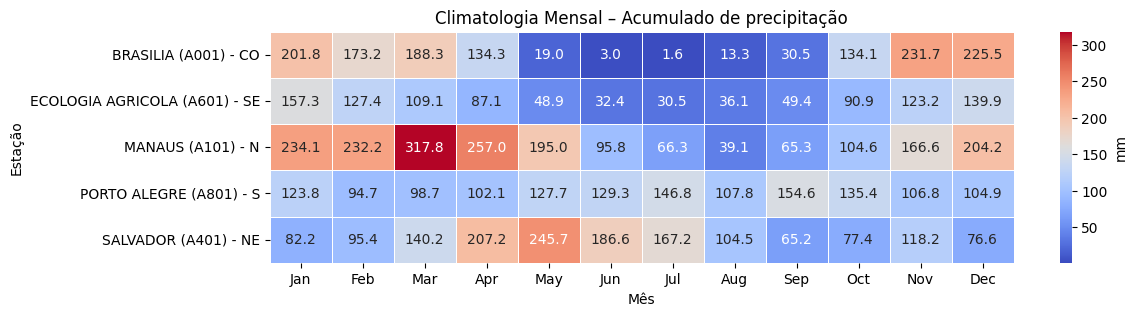

In [0]:
heatmap_plot(stations_data_pd, "precipitation", "mm", "Acumulado de precipitação")

#### Análise

**Manaus (N):** muito úmido o ano todo, pico em março (~ 320 mm) e “mínimo” ainda elevado em julho (~ 65 mm). **Brasília (CO):** estação chuvosa robusta no verão (>200 mm nov–mar) e estiagem quase nula em jun–jul. **Ecologia Agrícola (SE):** verão chuvoso (110–160 mm) e seca moderada em jun–ago (30–50 mm). **Salvador (NE):** regime bimodal, máximos em abr–mai e jun–jul, verão mais seco. **Porto Alegre (S):** chuva relativamente uniforme o ano todo (~95–155 mm).

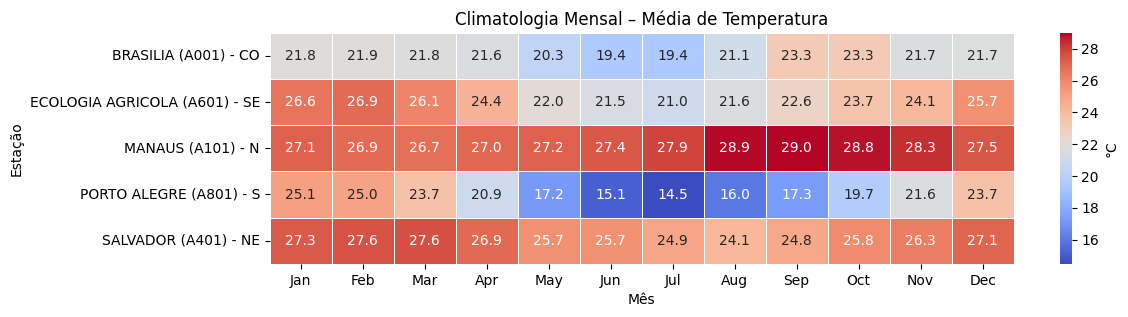

In [0]:
heatmap_plot(stations_data_pd, "temperature", "°C", "Média de Temperatura")

#### Análise

Temperatura média reflete três regimes: (1) **Equatorial – Manaus** fica quase estável (27–29 °C) o ano todo; (2) **Tropical – Salvador e Ecologia Agrícola** mantêm-se quentes, mas caem 2-4 °C no inverno, enquanto Brasília esfria mais (-3 °C) entre maio-agosto; (3) **Subtropical – Porto Alegre** apresenta a maior amplitude, indo de ~25 °C no verão a 14–16 °C em junho-agosto. Em síntese, a sazonalidade térmica cresce de Norte para Sul e de áreas costeiras/oceânicas para o interior.

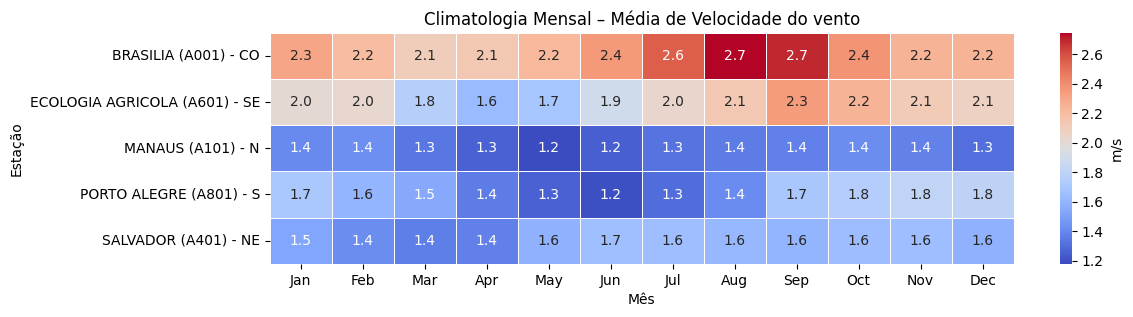

In [0]:
heatmap_plot(stations_data_pd, "wind_speed", "m/s", "Média de Velocidade do vento")

#### Análise

**Brasília** alcança os maiores valores médios e um pico de ~ 2,7 m/s em agosto - setembro, típico do período seco do Planalto quando o gradiente de pressão se intensifica. **Ecologia Agrícola (Sudeste)** mantém regime intermediário (1,6 - 2,3 m/s) com leve reforço na primavera, enquanto **Porto Alegre** sobe de ~ 1,2 m/s no inverno para ~ 1,8 m/s na primavera, refletindo a passagem mais frequente de frentes. **Salvador** apresenta ventos relativamente constantes perto de 1,6 m/s durante todo o ano, e **Manaus** exibe as menores velocidades (~ 1,2 - 1,4 m/s) com variação mínima, condizente com a densa cobertura amazônica e fraca sazonalidade dinâmica.

/home/spark-7e980c5c-4ef8-444d-8bfc-c1/.ipykernel/2547/command-8041530710054392-4294762677:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


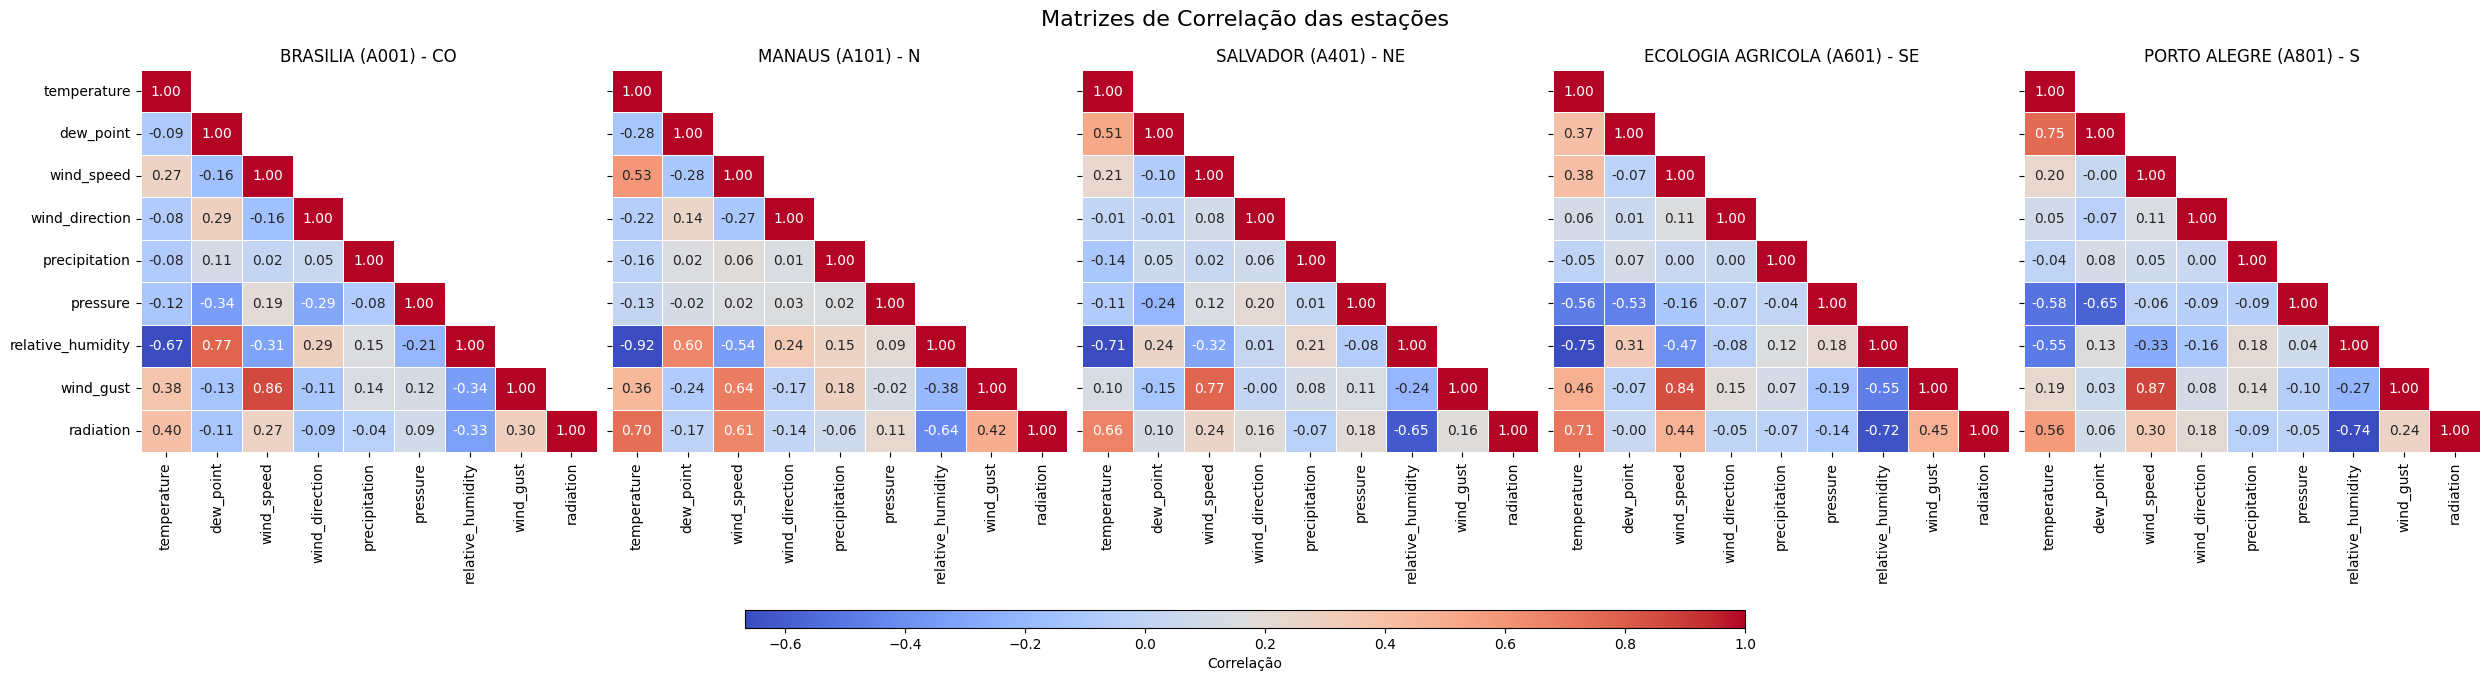

In [0]:
# Matrizes de correlação
data_columns = ['code', 'temperature', 'dew_point', 'wind_speed', 'wind_direction', 'precipitation', 'pressure', 'relative_humidity', 'wind_gust', 'radiation']
groups = stations_data_pd[data_columns].groupby('code')

fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)
fig.suptitle('Matrizes de Correlação das estações', fontsize=16, y=0.98)

for ax, (code, df) in zip(axes, groups):
    station = stations_longest[stations_longest.code == code].iloc[0]
    corr = df.drop(columns='code').corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    hm = sns.heatmap(
        corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
        linewidths=.5, cbar=False, ax=ax
    )
    ax.set_title(f'{station.city} ({code}) - {station.region}')

cbar_ax = fig.add_axes([0.30, -0.05, 0.40, 0.03])

fig.colorbar(
    axes[0].collections[0],
    cax=cbar_ax,
    orientation='horizontal',
    label='Correlação'
)

fig.tight_layout()

plt.show()

#### Análise

Em todas as estações, três correlações dominam: `temperatura` × `umidade relativa` (~ −0.60), `temperatura` × `radiação` (0.40 – 0.71) e `rajada` × `vento médio` (0.83 – 0.87); já `precipitação` mantém ρ≈0 com as demais variáveis, confirmando sua natureza episódica.

- **Manaus** exibe `temperatura` e `ponto de orvalho` praticamente colados (ρ = 0.92), sinal de ar saturado;
- **Brasília** reflete a estação seca, com `radiação alta` e `temperatura` elevada (ρ = 0.40) mas `ponto de orvalho` dissociado (ρ ≈ 0), enquanto `radiação` e umidade se opõem fortemente (ρ = −0.72);

- **Salvador** mantém correlação `radiação`–`temperatura` de 0.66, limitada por umidade (ρ = −0.71);

- No Sudeste, **Ecologia Agrícola** repete o padrão centro-oeste porém com seca mais branda e `rajadas` muito ligadas ao `vento` (ρ = 0.84);

- **Porto Alegre** destaca-se pela anticorrelação `temperatura–pressão` mais forte do grupo (ρ = −0.65), típica da passagem de frentes frias.

### Respostas para as perguntas levantadas no início da análise

- **A maior parte da rede do INMET é composta por estações antigas e ainda ativas?**
Sim, a rede nacional de estações do INMET é predominantemente composta por estações instaladas antes de 2015 e que continuam operando até hoje. Ao mesmo tempo, a presença significativa de estações novas e ativas indica esforços contínuos de expansão e modernização.

- **Como é a distribuição de estações por região?**
Com base no gráfico, a distribuição das estações por região é relativamente equilibrada, com leve concentração nas regiões Sudeste (SE) e Nordeste (NE). O Sudeste concentra aproximadamente 24,7% das estações, seguido de perto pelo Nordeste, com 24,4%. A região Centro-Oeste (CO) representa cerca de 18,7% do total, enquanto o Norte (N) possui 16,6%. A menor participação é observada no Sul (S), com aproximadamente 15,6% das estações.

- **Qual estação pode ser considerada a mais representativa de cada região?**
A distribuição das estações por região é equilibrada, com uma estação representativa em cada uma das cinco regiões do Brasil. No Centro-Oeste, a estação de Brasília (A001) possui 9.155 dias de registros. No Norte, a estação de Manaus (A101) conta com 9.153 dias. O Nordeste é representado por Salvador (A401), com 9.149 dias de dados. No Sul, a estação de Porto Alegre (A801) apresenta 9.017 dias de registros. Já o Sudeste é representado pela estação Ecologia Agrícola (A601), no Rio de Janeiro, com 9.155 dias. Todas as estações são classificadas como Old & Active, indicando operação contínua desde o ano 2000 até 2025, garantindo cobertura nacional e séries históricas longas para análise climática.

- **Quais os 5 estados com maior número de estações meteorológicas?**
Com base no gráfico de barras horizontais, os cinco estados com maior número de estações meteorológicas e, consequentemente, maior capacidade de acompanhamento das condições climáticas regionais são:
  - Minas Gerais (MG) – 69 estações
  - Bahia (BA) – 48 estações
  - Rio Grande do Sul (RS) – 45 estações
  - Mato Grosso do Sul (MS) – 45 estações
  - São Paulo (SP) – 43 estações

- **Quais são os 5 estados com menos estações meteorológicas no Brasil?**
Com base no gráfico, os cinco estados com menor número de estações meteorológicas, o que pode limitar o detalhamento espacial das análises meteorológicas e indicar a necessidade de expansão da rede de monitoramento, são:
  - Roraima (RR) – 3 estações
  - Amapá (AP) – 4 estações
  - Distrito Federal (DF) – 5 estações
  - Acre (AC) – 7 estações
  - Sergipe (SE) – 7 estações

- **Existe correlação entre precipitação e as demais variáveis medidas**
A climatologia indica que não há correlação linear relevante entre precipitação e as demais variáveis: em todos os cinco heatmaps, os coeficientes “precipitação × temperatura”, “precipitação × umidade”, “precipitação × radiação”, “precipitação × vento” e “precipitação × pressão” oscilam perto de 0 (-0,15 ≤ ρ ≤ 0,15). Isso confirma que a chuva diária é um fenômeno episódico.

- **A amplitude térmica anual cresce progressivamente do Norte para o Sul do Brasil?**
Sim. O conjunto mostra variação de ~2 °C em Manaus contra ~11 °C em Porto Alegre, confirmando aumento latitudinal da sazonalidade térmica.

### Autoavaliação

Ao final deste trabalho, considero que atingi os objetivos propostos no início do desenvolvimento do MVP. Consegui estruturar o processo de ingestão, tratamento e análise dos dados, integrando informações meteorológicas e cadastrais das estações de forma consistente, o que permitiu responder às perguntas definidas nos objetivos.

As principais dificuldades encontradas estiveram relacionadas à padronização e qualidade dos dados, especialmente no tratamento de tipos, valores ausentes e nomes de colunas. Também houve desafios na integração dos dados e na organização das camadas do modelo, exigindo ajustes ao longo do desenvolvimento.

Como trabalhos futuros, pretendo ampliar o conjunto de dados, incluir novas variáveis e desenvolver análises mais avançadas, além de aprimorar as visualizações e automatizar o pipeline, tornando a solução mais robusta e enriquecendo meu portfólio.